Import libraries

In [49]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

In [50]:
macro = pd.read_csv('../Data/macro.csv',parse_dates=['timestamp'])
train = pd.read_csv('../Data/train.csv',parse_dates=['timestamp'])
test = pd.read_csv('../Data/test.csv',parse_dates=['timestamp'])

In [51]:
macro.tail()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
2480,2016-10-16,44.3677,19979.4,-0.60,531.0,601.9,133.16,5.823,2.6,62.9573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2481,2016-10-17,44.3677,19979.4,-0.60,531.0,601.9,133.16,5.823,2.6,63.0856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2482,2016-10-18,44.3677,19979.4,-0.60,531.0,601.9,133.16,5.823,2.6,62.9512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2483,2016-10-19,44.3677,19979.4,-0.60,531.0,601.9,133.16,5.823,2.6,62.9512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2484,50.2,45.7100,38.4,29.78,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Drop the last row of macro and convert timestamp for merging
macro.drop(2484,inplace=True)
macro.timestamp = pd.to_datetime(macro.timestamp)

In [53]:
train = pd.merge(train, macro, how='left', on='timestamp')
test = pd.merge(test, macro, how='left', on='timestamp')
del macro

In [54]:
ID = test.id
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

In [55]:
list(train.columns)

['timestamp',
 'full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'product_type',
 'sub_area',
 'area_m',
 'raion_popul',
 'green_zone_part',
 'indust_part',
 'children_preschool',
 'preschool_quota',
 'preschool_education_centers_raion',
 'children_school',
 'school_quota',
 'school_education_centers_raion',
 'school_education_centers_top_20_raion',
 'hospital_beds_raion',
 'healthcare_centers_raion',
 'university_top_20_raion',
 'sport_objects_raion',
 'additional_education_raion',
 'culture_objects_top_25',
 'culture_objects_top_25_raion',
 'shopping_centers_raion',
 'office_raion',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'full_all',
 'male_f',
 'female_f',
 'young_all',
 'young_male',
 'young_female',
 'work_all',
 'work_male',
 'work_female',
 'ekder_all',
 'ekd

Deal with outliers for important features

In [56]:
# Area data
# Remove data points with full_sq < life_sq and full_sq < kitch_sq
badindex = train[(train.full_sq<train.life_sq)&(train.full_sq<train.kitch_sq)].index
train.loc[badindex,['full_sq','life_sq','kitch_sq']] = np.NaN
badindex = train[train.full_sq<train.life_sq].index
train.loc[badindex,['full_sq','life_sq']] = np.NaN
badindex = train[train.full_sq<train.kitch_sq].index
train.loc[badindex,['full_sq','kitch_sq']] = np.NaN

badindex = test[(test.full_sq<test.life_sq)&(test.full_sq<test.kitch_sq)].index
test.loc[badindex,['full_sq','life_sq','kitch_sq']] = np.NaN
badindex = test[test.full_sq<test.life_sq].index
test.loc[badindex,['full_sq','life_sq']] = np.NaN
badindex = test[test.full_sq<test.kitch_sq].index
test.loc[badindex,['full_sq','kitch_sq']] = np.NaN

Text(0.5,16.8,'train data')

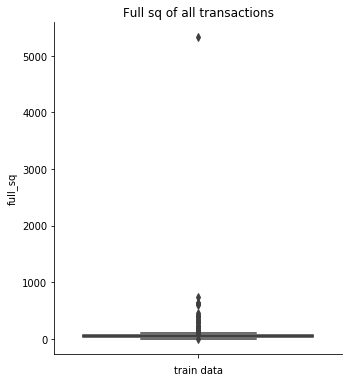

In [57]:
# Remove extreme values
p = sns.catplot(y='full_sq',data=train,kind='box')
plt.title('Full sq of all transactions')
plt.xlabel('train data')

In [58]:
badindex = train[(train.full_sq<5)|(train.full_sq>1000)].index
train.loc[badindex,'full_sq'] = np.NaN

Text(0.5,16.8,'data')

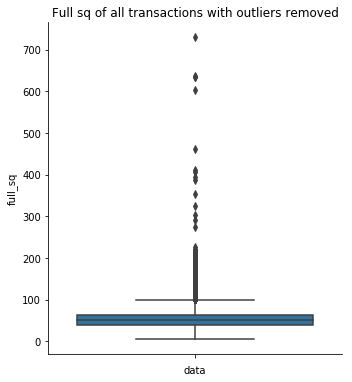

In [59]:
p = sns.catplot(y='full_sq',data=train,kind='box')
plt.title('Full sq of all transactions with outliers removed')
plt.xlabel('data')

Text(0.5,16.8,'test data')

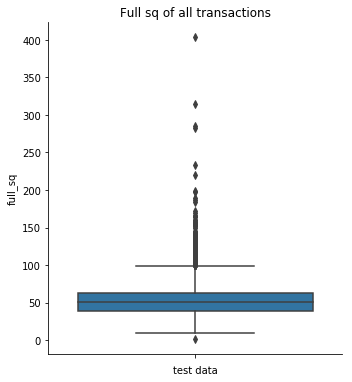

In [60]:
p = sns.catplot(y='full_sq',data=test,kind='box')
plt.title('Full sq of all transactions')
plt.xlabel('test data')

In [61]:
badindex = test[(test.full_sq<5)|(test.full_sq>1000)].index
test.loc[badindex,'full_sq'] = np.NaN

Text(0.5,16.8,'test data')

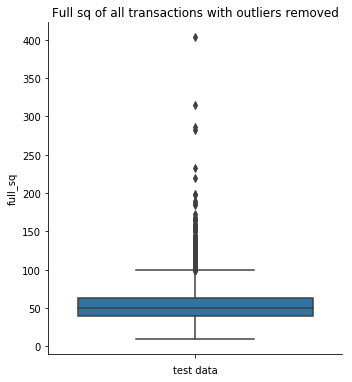

In [62]:
p = sns.catplot(y='full_sq',data=test,kind='box')
plt.title('Full sq of all transactions with outliers removed')
plt.xlabel('test data')

Text(0.5,16.8,'train data')

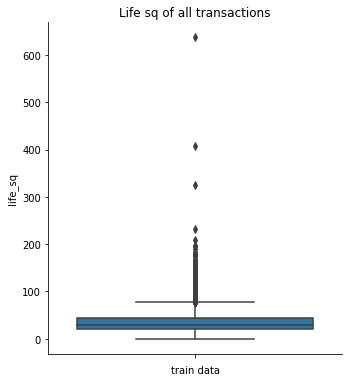

In [63]:
p = sns.catplot(y='life_sq',data=train,kind='box')
plt.title('Life sq of all transactions')
plt.xlabel('train data')

In [64]:
badindex = train[(train.life_sq<5)|(train.life_sq>1000)].index
train.loc[badindex,'life_sq'] = np.NaN

Text(0.5,16.8,'train data')

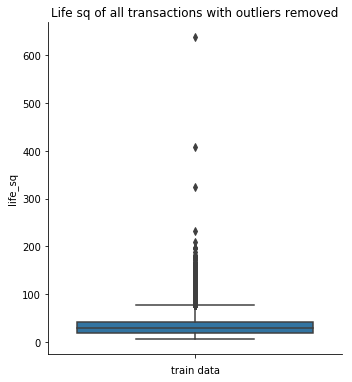

In [65]:
p = sns.catplot(y='life_sq',data=train,kind='box')
plt.title('Life sq of all transactions with outliers removed')
plt.xlabel('train data')

Text(0.5,16.8,'test data')

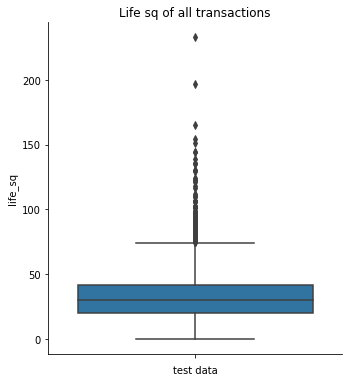

In [66]:
p = sns.catplot(y='life_sq',data=test,kind='box')
plt.title('Life sq of all transactions')
plt.xlabel('test data')

In [67]:
badindex = test[(test.life_sq<5)|(test.life_sq>1000)].index
test.loc[badindex,'life_sq'] = np.NaN

Text(0.5,16.8,'test data')

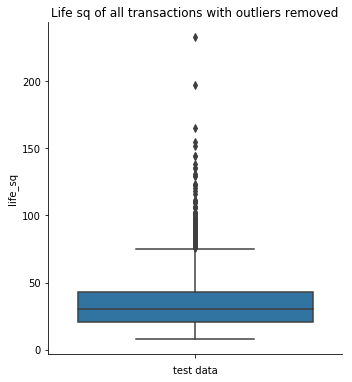

In [68]:
p = sns.catplot(y='life_sq',data=test,kind='box')
plt.title('Life sq of all transactions with outliers removed')
plt.xlabel('test data')

In [69]:
# Floor data
badindex = train[train.floor>train.max_floor].index
train.loc[badindex,['floor','max_floor']] = np.NaN
badindex = test[test.floor>test.max_floor].index
test.loc[badindex,['floor','max_floor']] = np.NaN

Text(0.5,1,'Material stat in train data')

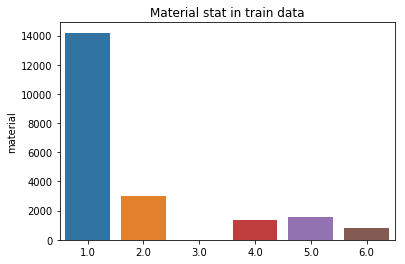

In [70]:
# Material data
p = sns.barplot(x=train.material.value_counts().index,y=train.material.value_counts())
plt.title('Material stat in train data')

Text(0.5,1,'Material stat in test data')

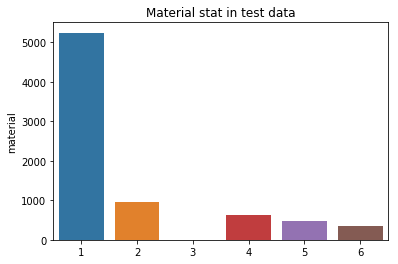

In [71]:
p = sns.barplot(x=test.material.value_counts().index,y=test.material.value_counts())
plt.title('Material stat in test data')

In [72]:
# Replace material 3 with the mode
badindex = train[train.material==3].index
train.loc[badindex,'material'] = 1
badindex = test[test.material==3].index
test.loc[badindex,'material'] = 1

Text(0,0.5,'counts')

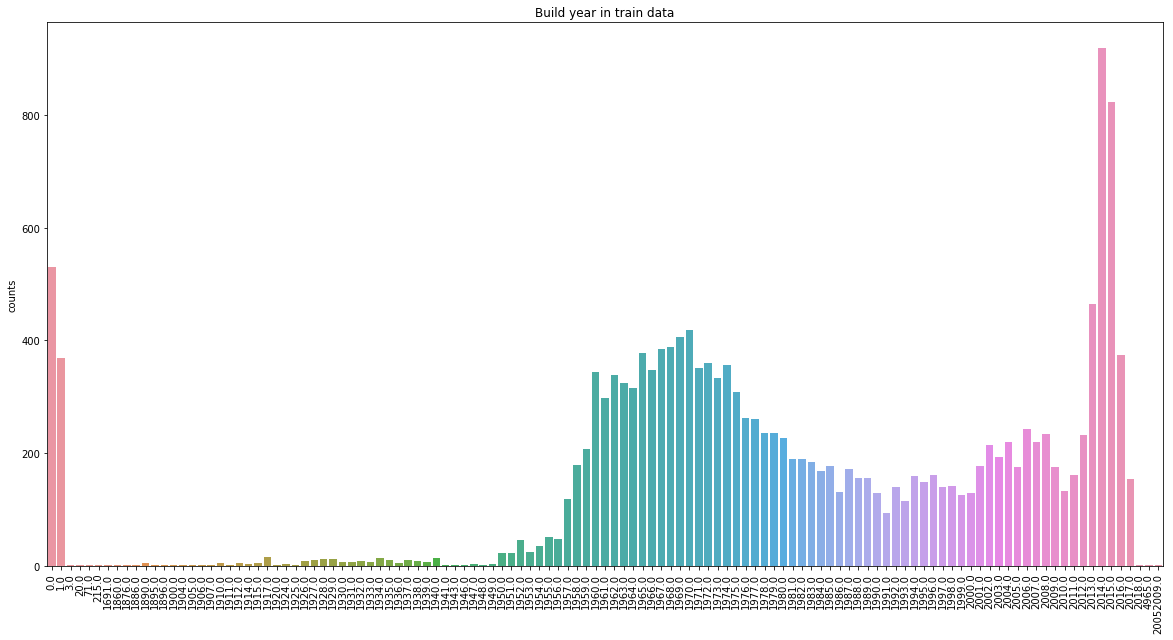

In [73]:
#Build Year
plt.figure(figsize=(20,10))
p = sns.barplot(train.build_year.dropna().value_counts().index,train.build_year.dropna().value_counts())
plt.xticks(rotation=90)
plt.title('Build year in train data')
plt.ylabel('counts')

Text(0,0.5,'counts')

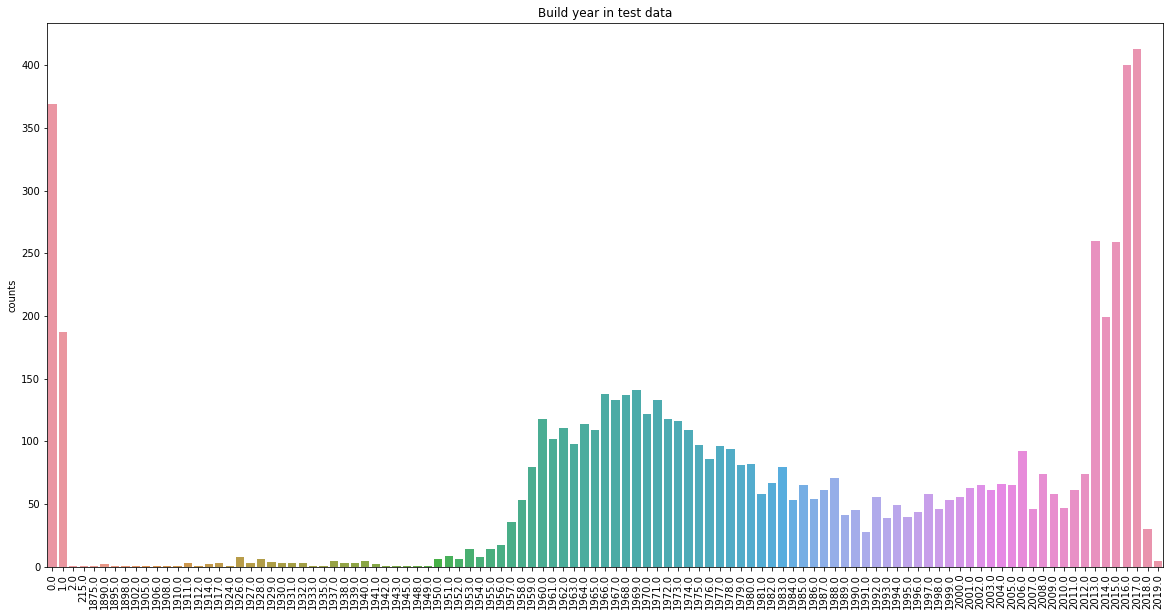

In [82]:
plt.figure(figsize=(20,10))
p = sns.barplot(test.build_year.dropna().value_counts().index,test.build_year.dropna().value_counts())
plt.xticks(rotation=90)
plt.title('Build year in test data')
plt.ylabel('counts')

In [102]:
badindex = train[train.build_year<300].index

In [103]:
badindex = train[train.build_year>2018].index
train.loc[badindex,'build_year'] = np.NaN
badindex = train[train.build_year<300].index
train.loc[badindex,'build_year'] = train.loc[badindex,'timestamp'].apply(lambda x: x.year) - train.loc[badindex,'build_year']
badindex = test[test.build_year>2018].index
test.loc[badindex,'build_year'] = np.NaN
badindex = test[test.build_year<300].index
test.loc[badindex,'build_year'] = test.loc[badindex,'timestamp'].apply(lambda x: x.year) - test.loc[badindex,'build_year']

Text(0.5,1,'State stat in train data')

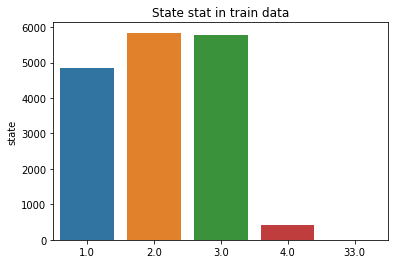

In [106]:
# States
p = sns.barplot(x=train.state.value_counts().index,y=train.state.value_counts())
plt.title('State stat in train data')

Text(0.5,1,'State stat in test data')

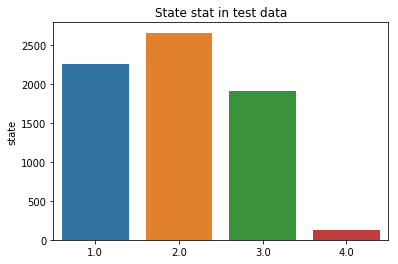

In [107]:
p = sns.barplot(x=test.state.value_counts().index,y=test.state.value_counts())
plt.title('State stat in test data')

In [108]:
badindex = train[train.state==33].index
train.loc[badindex,'state'] = train.state.mode()

Text(0,0.5,'Price per sq of train data')

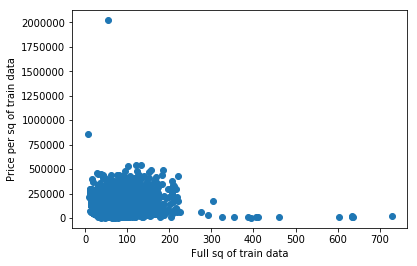

In [109]:
# Remove extreme high price per sq
plt.scatter(train.full_sq,train.price_doc/train.full_sq)
plt.xlabel('Full sq of train data')
plt.ylabel('Price per sq of train data')

In [110]:
badindex = train[train.price_doc/train.full_sq>700000].index
train = train.drop(badindex)

Text(0,0.5,'Number of values')

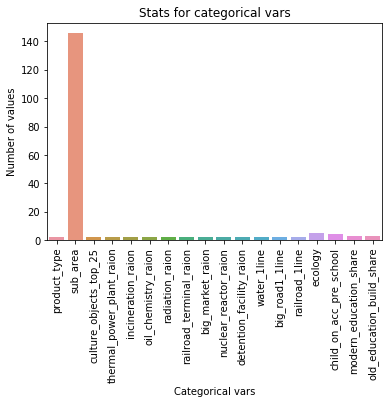

In [111]:
# Encoding categorical data
ObjVar = train.columns[train.dtypes=='object']
ValueCount = []
for x in ObjVar:
    ValueCount.append(len(train[x].value_counts()))
p = sns.barplot(ObjVar,ValueCount)
plt.title('Stats for categorical vars')
plt.xticks(rotation=90)
plt.xlabel('Categorical vars')
plt.ylabel('Number of values')

Text(0.5,1,'Log price by Month # from 2011-01 in train data')

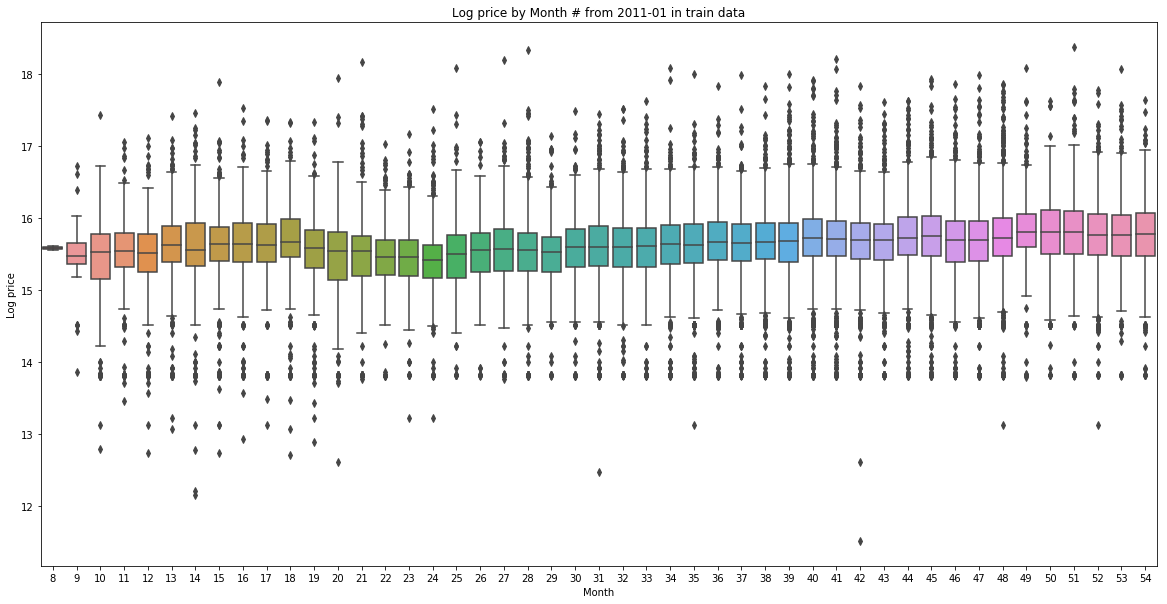

In [120]:
# First take a look at the price and timestamp relationship
train['Year'] = train.timestamp.apply(lambda x: x.year)
test['Year'] = test.timestamp.apply(lambda x: x.year)
train['Month'] = train.timestamp.apply(lambda x:(x.year-2011)*12+x.month)
test['Month'] = test.timestamp.apply(lambda x:(x.year-2011)*12+x.month)
train['Log_Price'] = np.log1p(train.price_doc)
plt.figure(figsize=(20,10))
p = sns.boxplot(x='Month',y='Log_Price',data=train)
plt.xlabel('Month')
plt.ylabel('Log price')
plt.title('Log price by Month # from 2011-01 in train data')

Text(0.5,1,'Log price by sub area in train data')

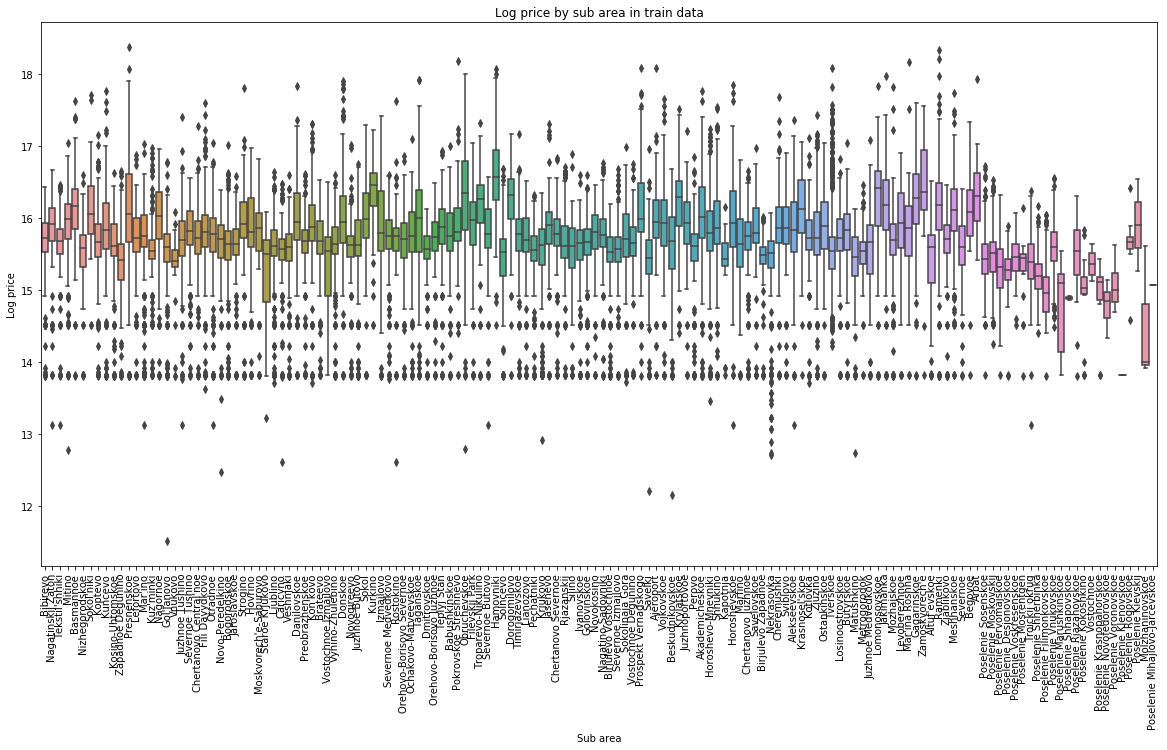

In [121]:
# Price is not much affected by the time of sale, we will keep Year/Month columns but drop timestamp for training
# Sub area data
plt.figure(figsize=(20,10))
p = sns.boxplot(x='sub_area',y='Log_Price',data=train)
plt.xlabel('Sub area')
plt.ylabel('Log price')
plt.xticks(rotation=90)
plt.title('Log price by sub area in train data')

In [140]:
# Divide sub_area into 3 categories
AreaValue = train.Log_Price.groupby(train.sub_area).mean().apply(lambda x: 'Low' if x<=15 else 'Medium' if x>15 and x<=16 else 'High')
train.sub_area = train.sub_area.map(AreaValue)
test.sub_area = test.sub_area.map(AreaValue)

In [171]:
# Convert the features 'child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share' from macro data into numerical vars
Features = ['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share']
for i in Features:
    train[i] = train[i].apply(lambda x: np.NaN if x=='#!' else x).apply(lambda x: str(x).replace(',','')).apply(lambda x: np.NaN if (x=='nan') else int(x))
    test[i] = test[i].apply(lambda x: np.NaN if x=='#!' else x).apply(lambda x: str(x).replace(',','')).apply(lambda x: np.NaN if (x=='nan') else int(x))

Text(0,0.5,'Number of values')

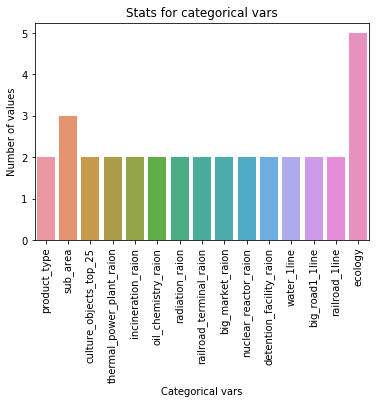

In [175]:
# Categorical vars after preprocessing
ObjVar = train.columns[train.dtypes=='object']
ValueCount = []
for x in ObjVar:
    ValueCount.append(len(train[x].value_counts()))
p = sns.barplot(ObjVar,ValueCount)
plt.title('Stats for categorical vars')
plt.xticks(rotation=90)
plt.xlabel('Categorical vars')
plt.ylabel('Number of values')

In [177]:
# OneHot encoding for object variables
for x in ObjVar:
    temp = pd.get_dummies(train[x])
    temp.columns = x+'_'+temp.columns
    train = train.join(temp).drop(x,axis=1)
    temp = pd.get_dummies(test[x])
    temp.columns = x+'_'+temp.columns
    test = test.join(temp).drop(x,axis=1) 

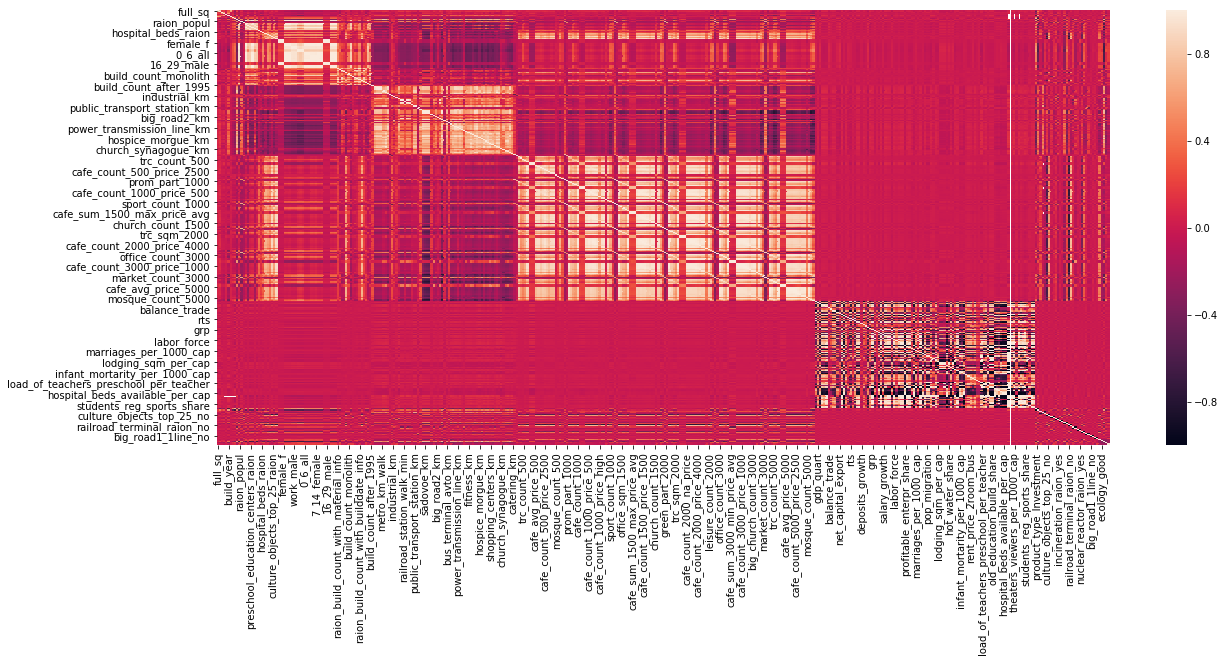

In [184]:
# Now look at feature correlations
plt.figure(figsize=(20,8))
p = sns.heatmap(train.drop(['timestamp','price_doc','Log_Price'],axis=1).corr())

In [185]:
# Remove perfectly correlated features
correlation = train.drop(['timestamp','price_doc','Log_Price'],axis=1).corr()
count = 0
dupfeature = []
for x in correlation.columns:
    for y in correlation[x].index[count:]:
        if correlation.loc[x,y]==1 and x!=y:
            dupfeature.append(y)
    count += 1
train = train.drop(dupfeature,axis=1)
test = test.drop(dupfeature,axis=1)

Text(0.5,1,'Missing values in train data')

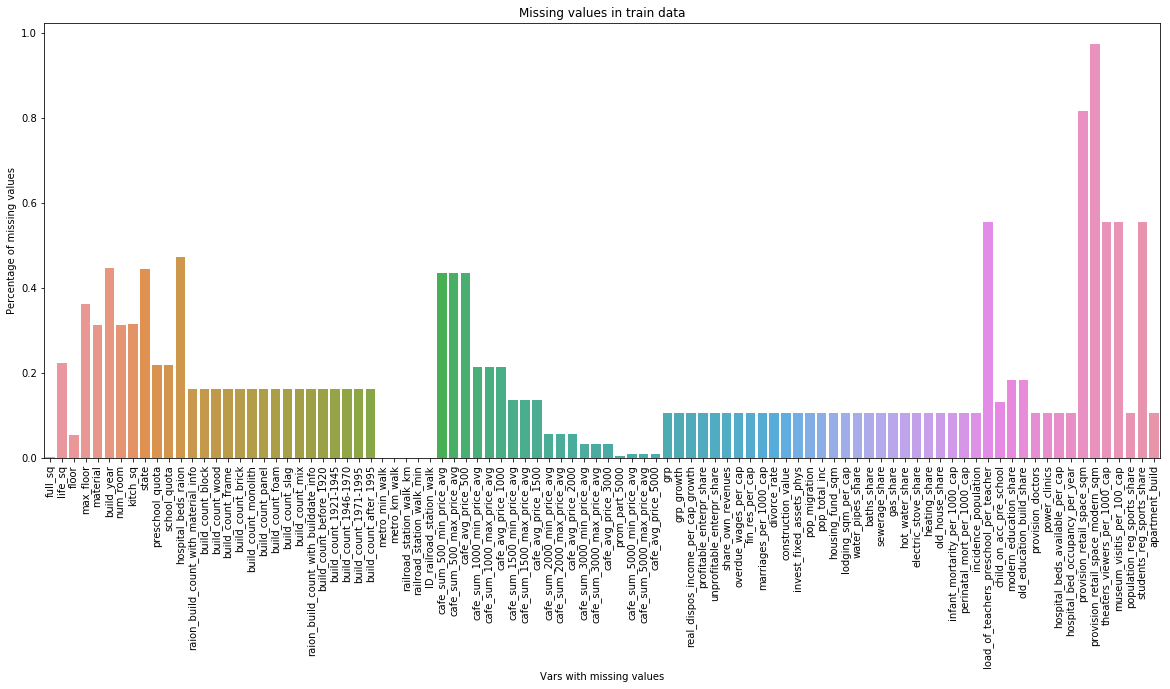

In [193]:
# Now take a look at missing values
index = train.columns[train.isnull().sum()>0]
MissingVal = train[index].isnull().sum()/train.shape[0]
plt.figure(figsize=(20,8))
p = sns.barplot(index,MissingVal)
plt.xticks(rotation=90)
plt.xlabel('Vars with missing values')
plt.ylabel('Percentage of missing values')
plt.title('Missing values in train data')

In [196]:
# Drop vars with missing values > 60%
Features = MissingVal[MissingVal>0.6].index
train = train.drop(Features,axis=1)
test = test.drop(Features,axis=1)

In [202]:
# Train the data using xgb model
train_y = train.Log_Price
train_X = train.drop(["timestamp", "price_doc", "Log_Price"], axis=1)
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, label=train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

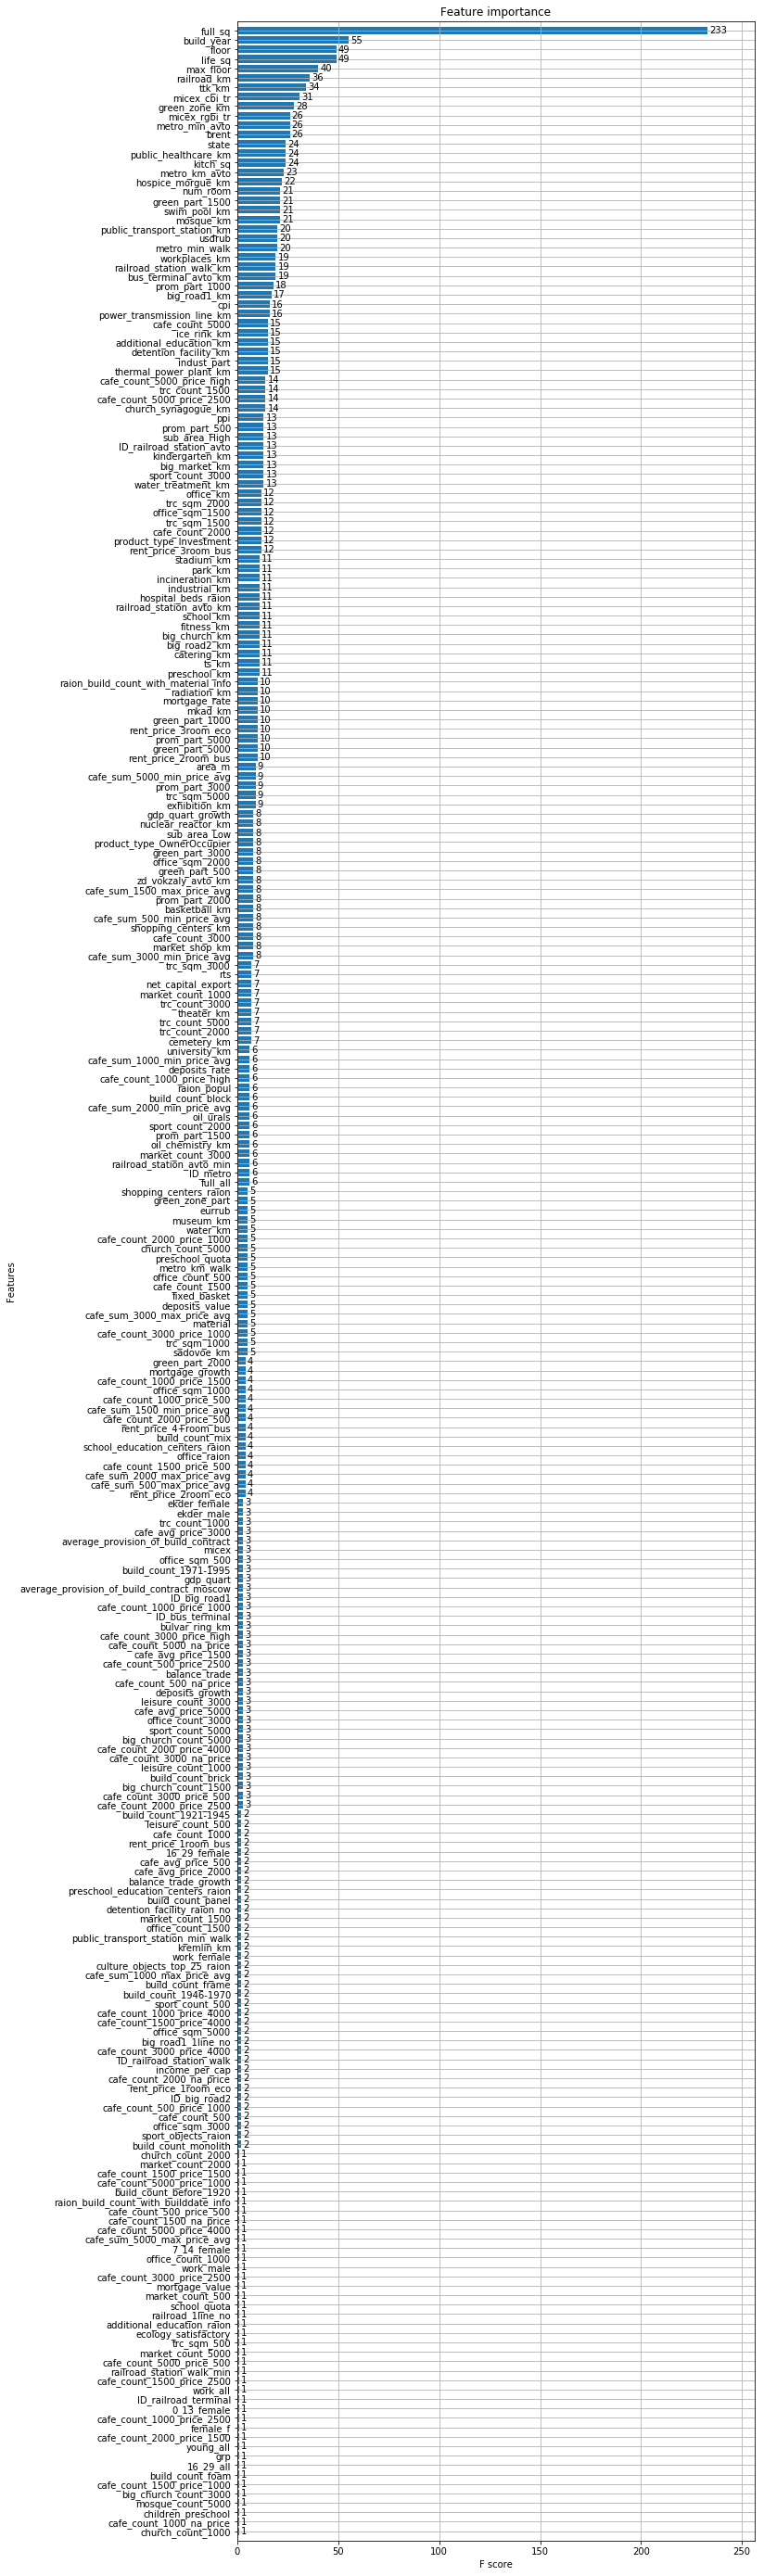

In [209]:
fig, ax = plt.subplots(figsize=(10,50))
p = xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

In [ ]:
# Continue 